In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import dask.dataframe as dd
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import random

In [2]:
def assemble_initial_location_summary(site_name, low_freq_threshold, high_freq_threshold, type_tag, save=True):
    location_df = dd.read_csv(f'../data/raw/{site_name}/*.csv').compute()
    anchor_start_times = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False) + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
    anchor_end_times = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False) + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S')
    location_df.insert(0, 'call_end_time', anchor_end_times)
    location_df.insert(0, 'call_start_time', anchor_start_times)
    location_df.insert(0, 'ref_time', anchor_start_times)
 
    if type_tag != "":
        location_df = location_df.loc[(location_df["high_freq"]).astype('float64') < high_freq_threshold]
        location_df = location_df.loc[(location_df["low_freq"]).astype('float64') > low_freq_threshold]

    if save:
        location_df.to_csv(f'../data/2022_bd2_summary/{site_name}/bd2__{type_tag}{site_name}_2022.csv')

    return location_df

def construct_activity_arr_from_location_summary(location_df, dc_tag):
    site_name = location_df['Site name'].values[0].split()[0]
    all_processed_filepaths = sorted(list(map(str, list(Path(f'../data/raw/{site_name}').iterdir()))))

    all_processed_datetimes = pd.to_datetime(all_processed_filepaths, format="%Y%m%d_%H%M%S", exact=False)
    datetimes_with_calls_detected = pd.to_datetime(location_df["input_file"].unique(), format="%Y%m%d_%H%M%S", exact=False)
    num_of_detections = location_df.groupby(["input_file"])["input_file"].count()
    num_of_detections.index = datetimes_with_calls_detected

    num_of_detections = add_rows_for_absence(num_of_detections, all_processed_datetimes, datetimes_with_calls_detected)
    activity_arr = pd.DataFrame(list(zip(num_of_detections.index, num_of_detections.values)), columns=["Date_and_Time_UTC", f"Number_of_Detections ({dc_tag})"])
    
    return activity_arr

def construct_activity_grid(activity_arr, dc_tag):
    activity_datetimes = pd.to_datetime(activity_arr["Date_and_Time_UTC"].values)
    activity_dates = activity_datetimes.strftime("%m/%d/%y").unique()
    activity_times = activity_datetimes.strftime("%H:%M").unique()

    activity = activity_arr[f"Number_of_Detections ({dc_tag})"].values.reshape(len(activity_dates), len(activity_times)).T

    on = int(dc_tag.split('e')[0])
    total = int(dc_tag.split('e')[1])
    if on == total:
        activity_df = pd.DataFrame(activity, index=activity_times, columns=activity_dates)
    else:
        recover_ratio = total / on
        activity_df = pd.DataFrame(recover_ratio*activity, index=activity_times, columns=activity_dates)

    return activity_df

def construct_presence_grid(activity_arr, dc_tag):
    activity_datetimes = pd.to_datetime(activity_arr["Date_and_Time_UTC"].values)
    activity_dates = activity_datetimes.strftime("%m/%d/%y").unique()
    activity_times = activity_datetimes.strftime("%H:%M").unique()

    presence_arr = activity_arr.copy()
    presence_arr[f"Number_of_Detections ({dc_tag})"].mask(presence_arr[f"Number_of_Detections ({dc_tag})"] > 0, 1, inplace=True)
    
    presence = presence_arr[f"Number_of_Detections ({dc_tag})"].values.reshape(len(activity_dates), len(activity_times)).T
    presence_df = pd.DataFrame(presence, index=activity_times, columns=activity_dates)

    return presence_df

def add_rows_for_absence(num_of_detections, all_processed_datetimes, datetimes_with_calls_detected):
    for file in all_processed_datetimes:
        if (not(file in datetimes_with_calls_detected)):
            num_of_detections[file] = 0
    num_of_detections = num_of_detections.sort_index()

    return num_of_detections

In [3]:
def rect(pos):
    r = plt.Rectangle(pos-0.505, 1, 1, facecolor="none", edgecolor="k", linewidth=0.6)
    plt.gca().add_patch(r)


In [4]:
def plot_activity_grid(activity_df):

    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(10, 10))
    plt.title(f"Activity from Telephone Field", loc='left', y=1.05)
    plt.imshow(1+activity_df, norm=colors.LogNorm(vmin=1, vmax=10e3))
    plt.yticks(np.arange(0, len(activity_df.index), 2)-0.5, activity_df.index[::2], rotation=50)
    plt.xticks(np.arange(0, len(activity_df.columns))-0.5, activity_df.columns, rotation=50)
    plt.ylabel('UTC Time (HH:MM)')
    plt.xlabel('Date (MM/DD/YY)')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_presence_grid(presence_df, color="cyan"):
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(10, 10))
    plt.title(f"Presence/Absence from Telephone Field", loc='left', y=1.05)
    masked_array = np.ma.masked_where(presence_df == 1, presence_df)
    cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
    cmap.set_bad(color=color, alpha=0.6)
    im = plt.imshow(masked_array, cmap=cmap)
    x, y = np.meshgrid(np.arange(presence_df.shape[1]), np.arange(presence_df.shape[0]))
    m = np.c_[x[presence_df == 1], y[presence_df == 1]]
    for pos in m:
        rect(pos)
    plt.ylabel("UTC Time (HH:MM)")
    plt.xlabel('Date (MM/DD/YY)')
    plt.yticks(np.arange(0, len(presence_df.index), 2)-0.5, presence_df.index[::2], rotation=50)
    plt.xticks(np.arange(0, len(presence_df.columns))-0.5, presence_df.columns, rotation=50)
    plt.grid(which="both", color='k')

    plt.tight_layout()
    plt.show()

In [5]:
def simulate_dutycycle_on_detections(location_df, cycle_length, percent_on):
    location_df['ref_time'] = pd.DatetimeIndex(location_df['ref_time'])
    location_df['call_end_time'] = pd.DatetimeIndex(location_df['call_end_time'])
    location_df['call_start_time'] = pd.DatetimeIndex(location_df['call_start_time'])\
    
    resampled_df = location_df.resample(f'{cycle_length}S', on='ref_time')
    cycle_length_applied_df = resampled_df.apply(lambda group: assign_start_times_in_ref(group))
    dc_applied_df = cycle_length_applied_df.loc[cycle_length_applied_df['end_time_wrt_ref'] <= round(percent_on*cycle_length)]
    return dc_applied_df


def prepare_summary_for_plotting_with_duty_cycle(site_name, cycle_length, percent_on, type_tag):
    location_df = pd.read_csv(f'../data/2022_bd2_summary/{site_name}/bd2__{type_tag}{site_name}_2022.csv', index_col=0)
    plottable_location_df = simulate_dutycycle_on_detections(location_df, cycle_length, percent_on)
    dc_tag = f"{round(percent_on*cycle_length)}e{cycle_length}"
    plottable_location_df.to_csv(f"../data/2022_bd2_summary/{site_name}/duty_cycled/simulated_schemes/bd2__{type_tag}{site_name}_2022_{dc_tag}.csv")

    return plottable_location_df


def assign_start_times_in_ref(group):
    
    if type(group.name) == pd._libs.tslibs.timestamps.Timestamp:
        group.insert(0, 'end_time_wrt_ref', (group['call_end_time'] - group.name).dt.total_seconds())
        group.insert(0, 'start_time_wrt_ref', (group['call_start_time'] - group.name).dt.total_seconds())
        group.insert(0, 'ref_time', group.name)
        group.pop('start_time')
        group.pop('end_time')

    return group

In [6]:
Path('../data/2022_bd2_summary/Central/duty_cycled/simulated_schemes/').mkdir(parents=True, exist_ok=True)
Path('../data/2022_bd2_summary/Telephone/duty_cycled/simulated_schemes/').mkdir(parents=True, exist_ok=True)

In [7]:
type_tag = ""
lf_freqs = [0, 46000]
hf_freqs = [35000, 125000]
site_name = "Central Pond"
site = site_name.split()[0]
assemble_initial_location_summary(site, 0, 125000, type_tag)

,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name
0,2022-08-23 03:49:36.093500,2022-08-23 03:49:36.093500,2022-08-23 03:49:36.115700,1176.0935,1176.1157,22031.0,25081.0,Echolocation,Nyctalus leisleri,0.473,0.509,-1,/mnt/ubna_data_01/recover-20220825/UBNA_008/20...,recover-20220825,UBNA_008,Central Pond
1,2022-08-23 03:51:55.942500,2022-08-23 03:51:55.942500,2022-08-23 03:51:55.955000,1315.9425,1315.955,26328.0,31654.0,Echolocation,Nyctalus leisleri,0.266,0.535,-1,/mnt/ubna_data_01/recover-20220825/UBNA_008/20...,recover-20220825,UBNA_008,Central Pond
2,2022-08-23 03:51:56.421500,2022-08-23 03:51:56.421500,2022-08-23 03:51:56.431700,1316.4215,1316.4317,27187.0,34510.0,Echolocation,Eptesicus serotinus,0.282,0.567,-1,/mnt/ubna_data_01/recover-20220825/UBNA_008/20...,recover-20220825,UBNA_008,Central Pond
3,2022-08-23 03:51:56.740500,2022-08-23 03:51:56.740500,2022-08-23 03:51:56.750100,1316.7405,1316.7501,26328.0,35063.0,Echolocation,Eptesicus serotinus,0.333,0.576,-1,/mnt/ubna_data_01/recover-20220825/UBNA_008/20...,recover-20220825,UBNA_008,Central Pond
4,2022-08-23 03:51:57.465500,2022-08-23 03:51:57.465500,2022-08-23 03:51:57.479900,1317.4655,1317.4799,25468.0,31887.0,Echolocation,Nyctalus leisleri,0.296,0.576,-1,/mnt/ubna_data_01/recover-20220825/UBNA_008/20...,recover-20220825,UBNA_008,Central Pond
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,2022-08-29 12:35:22.061500,2022-08-29 12:35:22.061500,2022-08-29 12:35:22.068200,322.0615,322.0682,44375.0,52653.0,Echolocation,Pipistrellus pipistrellus,0.519,0.545,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
50,2022-08-29 12:35:22.154500,2022-08-29 12:35:22.154500,2022-08-29 12:35:22.161400,322.1545,322.1614,44375.0,58248.0,Echolocation,Pipistrellus pipistrellus,0.581,0.601,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
51,2022-08-29 12:35:22.246500,2022-08-29 12:35:22.246500,2022-08-29 12:35:22.253500,322.2465,322.2535,45234.0,58486.0,Echolocation,Pipistrellus pipistrellus,0.52,0.582,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
52,2022-08-29 12:35:22.439500,2022-08-29 12:35:22.439500,2022-08-29 12:35:22.446700,322.4395,322.4467,44375.0,59815.0,Echolocation,Pipistrellus pipistrellus,0.576,0.634,-1,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond


In [8]:
dc_tags = []

cycle_length = 1800
percent_on = 1.0
dc_tag = f"{round(percent_on*cycle_length)}e{cycle_length}"
dc_tags += [dc_tag]
activity_arr = construct_activity_arr_from_location_summary(prepare_summary_for_plotting_with_duty_cycle(site, cycle_length, percent_on, type_tag), dc_tag)

cycle_length = 1800
percent_on = 0.1667
dc_tag = f"{round(percent_on*cycle_length)}e{cycle_length}"
dc_tags += [dc_tag]
dc_dets = construct_activity_arr_from_location_summary(prepare_summary_for_plotting_with_duty_cycle(site, cycle_length, percent_on, type_tag), dc_tag)
activity_arr = pd.concat([activity_arr, dc_dets[f"Number_of_Detections ({dc_tag})"]], axis=1)

cycle_length = 360
percent_on = 0.167
dc_tag = f"{round(percent_on*cycle_length)}e{cycle_length}"
dc_tags += [dc_tag]
dc_dets = construct_activity_arr_from_location_summary(prepare_summary_for_plotting_with_duty_cycle(site, cycle_length, percent_on, type_tag), dc_tag)
activity_arr = pd.concat([activity_arr, dc_dets[f"Number_of_Detections ({dc_tag})"]], axis=1)

In [9]:
activity_arr.to_csv(f'../data/2022_bd2_summary/{site}/duty_cycled/dc__{type_tag}{site}_summary.csv')

In [10]:
activity_arr = pd.read_csv(f'../data/2022_bd2_summary/{site}/duty_cycled/dc__{type_tag}{site}_summary.csv', index_col=0)
activity_arr

,Date_and_Time_UTC,Number_of_Detections (1800e1800),Number_of_Detections (300e1800),Number_of_Detections (60e360)
0,2022-08-23 03:00:00,0,0,0
1,2022-08-23 03:30:00,95,0,0
2,2022-08-23 04:00:00,508,81,136
3,2022-08-23 04:30:00,358,68,60
4,2022-08-23 05:00:00,426,0,23
...,...,...,...,...
142,2022-08-29 11:00:00,13,0,0
143,2022-08-29 11:30:00,14,0,1
144,2022-08-29 12:00:00,94,22,33
145,2022-08-29 12:30:00,53,0,0


In [11]:
print(dc_tags)
len(activity_arr)/21

['1800e1800', '300e1800', '60e360']


7.0

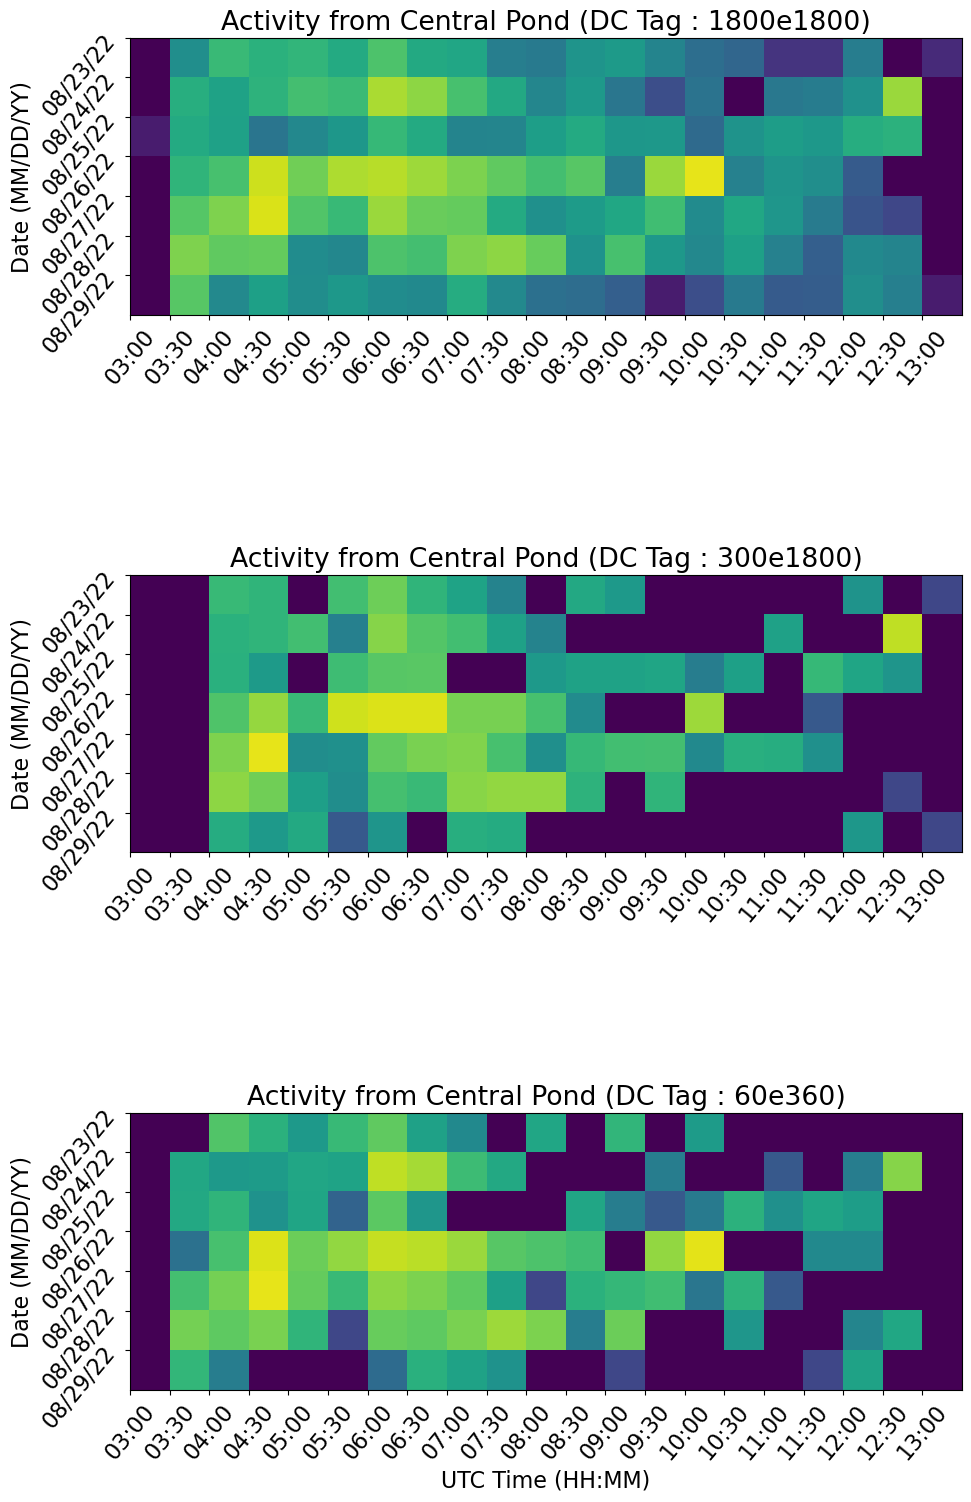

In [12]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, int(2.5*len(activity_arr)/21)))

for i, dc_tag in enumerate(dc_tags):
    activity_df = construct_activity_grid(activity_arr, dc_tag).T
    plt.subplot(len(dc_tags), 1, i+1)
    plt.title(f"Activity from {site_name} (DC Tag : {dc_tag})")
    plt.imshow(1+activity_df, norm=colors.LogNorm(vmin=1, vmax=10e3))
    plt.xticks(np.arange(0, len(activity_df.columns))-0.5, activity_df.columns, rotation=50)
    plt.yticks(np.arange(0, len(activity_df.index))-0.5, activity_df.index, rotation=50)
    plt.ylabel('Date (MM/DD/YY)')

plt.xlabel('UTC Time (HH:MM)')
plt.tight_layout()
plt.show()

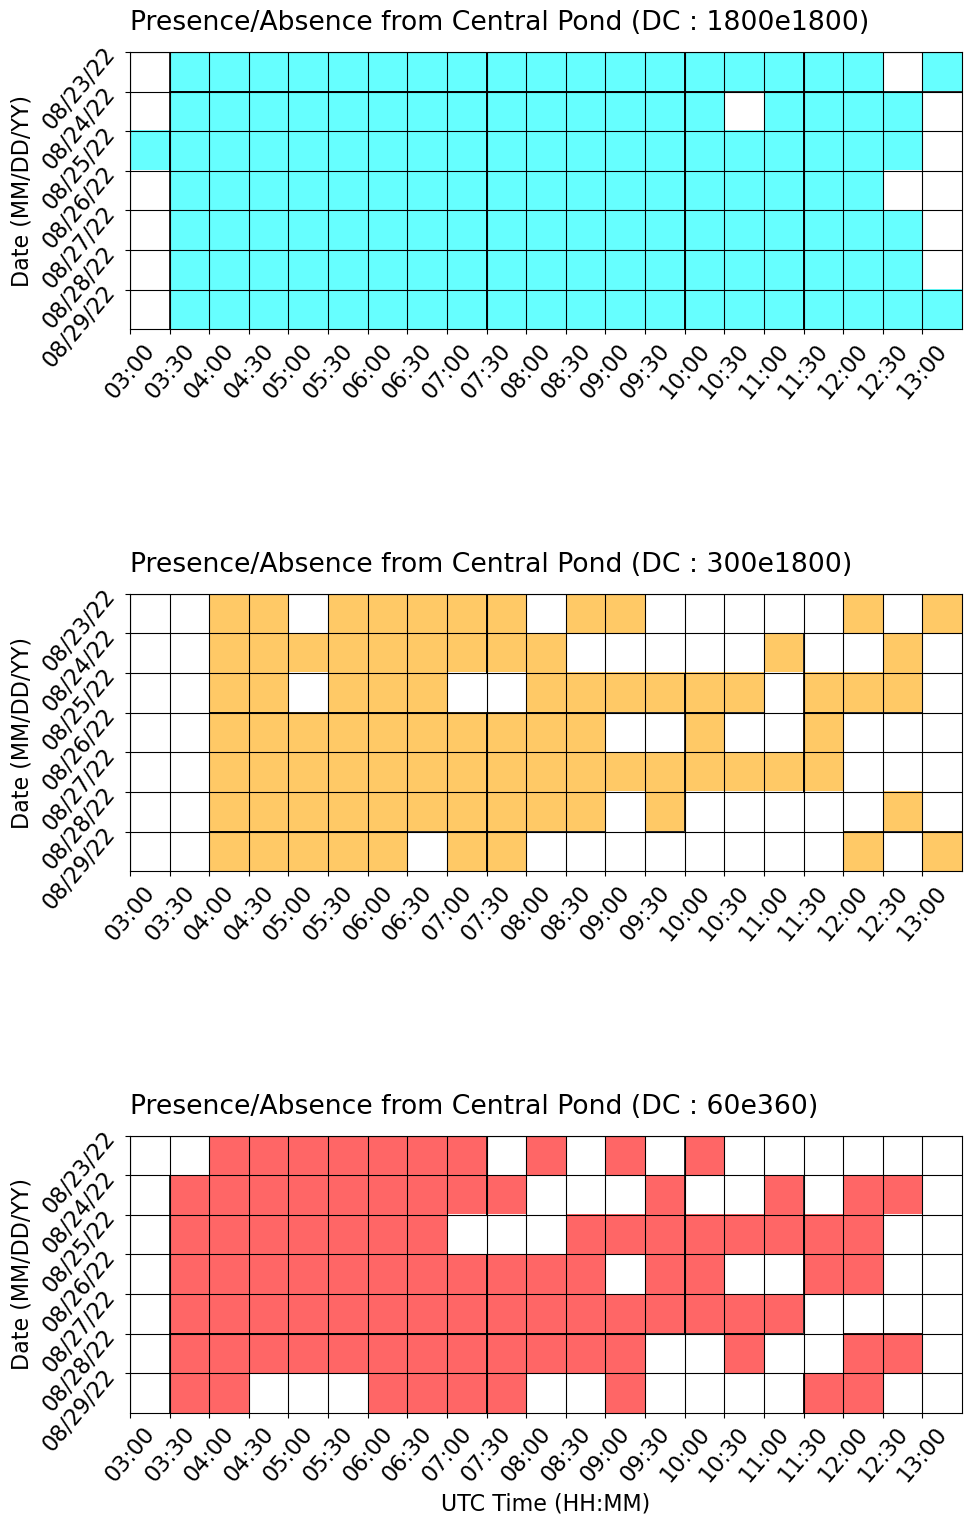

In [13]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, int(2.5*len(activity_arr)/21)))
colors = ['cyan', 'orange', 'red']

for i, dc_tag in enumerate(dc_tags):
    presence_df = construct_presence_grid(activity_arr, dc_tag).T
    plt.subplot(len(dc_tags), 1, i+1)
    plt.title(f"Presence/Absence from {site_name} (DC : {dc_tag})", loc='left', y=1.05)
    masked_array = np.ma.masked_where(presence_df == 1, presence_df)
    cmap = plt.get_cmap("Greys")  # Can be any colormap that you want after the cm
    cmap.set_bad(color=colors[i], alpha=0.6)
    im = plt.imshow(masked_array, cmap=cmap)
    x, y = np.meshgrid(np.arange(presence_df.shape[1]), np.arange(presence_df.shape[0]))
    m = np.c_[x[presence_df == 1], y[presence_df == 1]]
    for pos in m:
        rect(pos)
    plt.ylabel('Date (MM/DD/YY)')
    plt.xticks(np.arange(0, len(presence_df.columns), 1)-0.5, presence_df.columns[:], rotation=50)
    plt.yticks(np.arange(0, len(presence_df.index))-0.5, presence_df.index, rotation=50)
    plt.grid(which="both", color='k')


plt.xlabel("UTC Time (HH:MM)")
plt.tight_layout()
plt.show()